In [2]:
import xarray as xr # for data handling
import numpy as np # for maths
import matplotlib as mpl # plotlibrary
import matplotlib.pyplot as plt # for the plots 
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm # for making a log 10 colorscale
import cartopy # library for making maps
from cartopy import crs as ccrs # Projection Library
from cartopy.crs import Stereographic, PlateCarree, Mollweide # Map projections I use00
from cartopy.feature import LAND, COASTLINE # Vectordata of the Coastline and land for making the maps prettier
import cmocean

# Exercise 1

In [3]:
# Read levitus files (only works, when in same folder as this notebook)
levitus_file = "Levitus_climatology.nc"
levitus = xr.open_dataset(levitus_file, engine="scipy", decode_times=False)
levitus = levitus.rename({"X": "lon", "Y": "lat", "Z": "depth", "T": "month"}) # Rename the dimensions for easier understanding
levitus["month"] = np.ceil(levitus.month.values).astype(int)

In [4]:
# Read heatflux files (only works, when in same folder as this notebook)
ocean_atmosphere_heat_flux_file = "Ocean-atmosphere_heat-flux.nc"
oa_heat_flux = xr.open_dataset(ocean_atmosphere_heat_flux_file, engine="scipy", decode_times=False)
oa_heat_flux = oa_heat_flux.rename({"Y": "lat", "T": "month", "hfns": "heatflux"}) # Rename the dimensions for easier understanding 
oa_heat_flux["month"] = np.ceil(oa_heat_flux.month.values).astype(int)

# change the coordinates from -180 - 180 to 0 -360
oa_heat_flux_x_coord = oa_heat_flux["X"]
oa_heat_flux_x_coord_less_than_zero = oa_heat_flux_x_coord < 0

oa_heat_flux["lon"] = xr.where(
        oa_heat_flux_x_coord_less_than_zero, # take all the values, where X is less than zero
        oa_heat_flux_x_coord+360, # if true, add 360
        oa_heat_flux_x_coord, # if false take them verbatim
)

oa_heat_flux = (
        oa_heat_flux
        .sortby(["lon", "lat"]) # make sure to sort them
        .swap_dims({"X": "lon"}) # Make the new values to our dimension
        .drop_vars("X") # drop the old Dimension
)

In [5]:
# Define given values
specific_heat_capacity = 3.94e3
density = 1024

# get nice colormaps
cm_thermal = cmocean.cm.thermal
cm_balance = cmocean.cm.balance

In [6]:
# Set the basic mapping parameters
suptitle_size = 20 # Size for the main title 
title_size = 16 # Size for fonts
map_size = (16, 4) 
map_projection = Mollweide()

# Define a function that gives basic mapping parameters like land, coastline and gridlines
def basemap(ax):
        ax.add_feature(LAND)
        ax.add_feature(COASTLINE)
        ax.gridlines(
                draw_labels=["left", "bottom"], 
                y_inline=False, x_inline=False
        ) # Labels for  the coordinates are not within the map, but outside
        return ax

In [7]:
# Integrate Temperature over the topmost 1000 meters
integrated_temperature = (
        (
                levitus.temp # Take the Value Temperature
                + 273.15 # Transform to Kelvin
                )
        .integrate(coord="depth") # Integrate over the depth
).T # transpose the data 

In [8]:
# Calculate the Change in ocean heatcontent over JJA (August - June) and DJF (Feb - Dec) respectively
seconds_per_day = 24*60*60
days_in_long_month = 31
days_in_short_month = 30
days_in_february = 28

ocean_heatcontent_change_JJA = (
        density * specific_heat_capacity * 
        (
                integrated_temperature.sel(month=8) -
                integrated_temperature.sel(month=6)
        )/(seconds_per_day*61)
)
ocean_heatcontent_change_DJF = (
        density * specific_heat_capacity * 
        (
                integrated_temperature.sel(month=2) -
                integrated_temperature.sel(month=12)
        )/(seconds_per_day*59)
)

In [9]:
# Get the total heat by multiplying eachs month value with the number of days in that month, 
# summing everything and then multiply by 24*60*60, as the unit is given per second
seconds_per_day = 24*60*60
days_in_long_month = 31
days_in_short_month = 30
days_in_february = 28

heatflux_DJF = (
    (oa_heat_flux.heatflux.sel(month=[1, 12]).sum(dim="month")) * days_in_long_month + 
    oa_heat_flux.heatflux.sel(month=2) * days_in_february
    ) * seconds_per_day
heatflux_JJA = (
    (oa_heat_flux.heatflux.sel(month=[7, 8]).sum(dim="month")) * days_in_long_month +
    oa_heat_flux.heatflux.sel(month=6) * days_in_short_month
    ) * seconds_per_day

In [10]:
# Get the mean heatflux over the 3 months

heatflux_DJF = oa_heat_flux.heatflux.sel(month=[1, 2, 12]).mean(dim="month")
heatflux_JJA = oa_heat_flux.heatflux.sel(month=[6, 7, 8]).mean(dim="month")

In [24]:
heat_divergence_JJA = (-heatflux_JJA + ocean_heatcontent_change_JJA) * (-1)
heat_divergence_DJF = (-heatflux_DJF + ocean_heatcontent_change_DJF) * (-1)

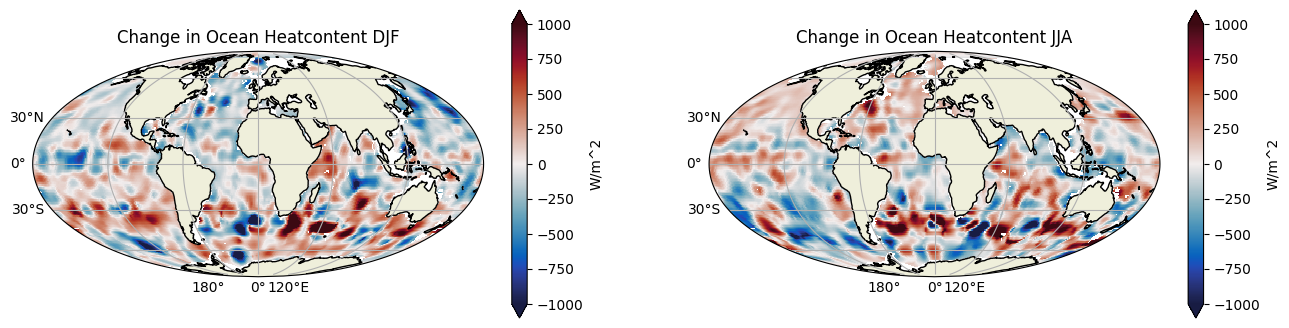

In [12]:
fig = plt.figure(figsize=map_size)
ax1 = fig.add_subplot(121, projection=Mollweide())
basemap(ax1)
ocean_heatcontent_change_DJF.plot(ax=ax1, transform=PlateCarree(), vmin=-1e3, vmax=1e3, cbar_kwargs={'label': "W/m^2"}, cmap=cm_balance)
ax1.set_title("Change in Ocean Heatcontent DJF")
ax2 = fig.add_subplot(122, projection=Mollweide())
basemap(ax2)
ocean_heatcontent_change_JJA.plot(ax=ax2, transform=PlateCarree(), vmin=-1e3, vmax=1e3, cbar_kwargs={'label': "W/m^2"}, cmap=cm_balance)
ax2.set_title("Change in Ocean Heatcontent JJA")
plt.show()

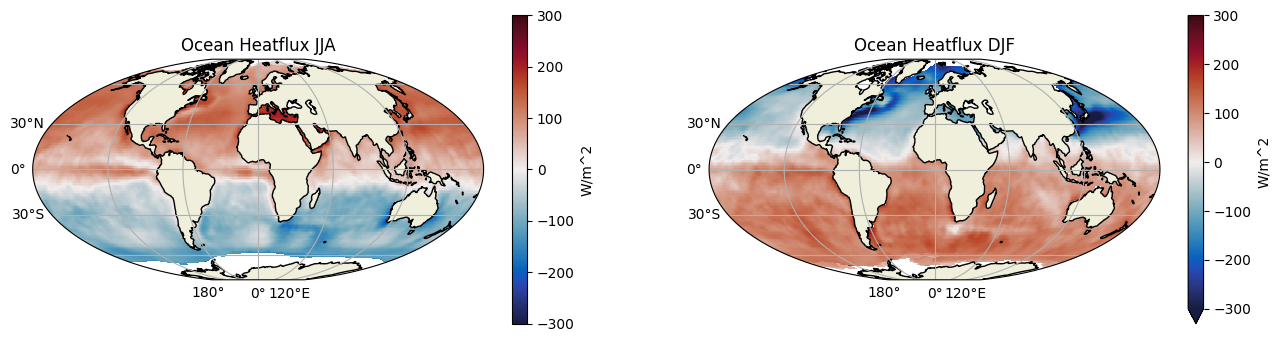

In [13]:
fig = plt.figure(figsize=map_size)
ax = fig.add_subplot(121, projection=Mollweide())
basemap(ax)
heatflux_JJA.plot(ax=ax, x="lon", y="lat", transform=PlateCarree(), vmin=-3e2, vmax=3e2, cbar_kwargs={'label': "W/m^2"}, cmap=cm_balance)
ax.set_title("Ocean Heatflux JJA")
ax = fig.add_subplot(122, projection=Mollweide())
basemap(ax)
heatflux_DJF.plot(ax=ax, x="lon", y="lat", transform=PlateCarree(), vmin=-3e2, vmax=3e2, cbar_kwargs={'label': "W/m^2"}, cmap=cm_balance)
ax.set_title("Ocean Heatflux DJF")
plt.show()

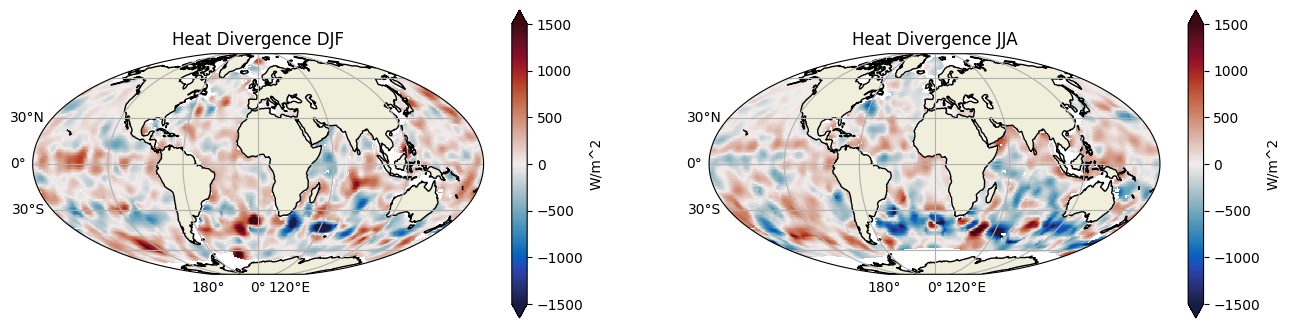

In [25]:
fig = plt.figure(figsize=map_size)
ax = fig.add_subplot(121, projection=Mollweide())
basemap(ax)
heat_divergence_DJF.plot(ax=ax, transform=PlateCarree(), vmin=-1.5e3, vmax=1.5e3, cbar_kwargs={'label': "W/m^2"}, cmap=cm_balance)
ax.set_title("Heat Divergence DJF")
ax2 = fig.add_subplot(122, projection=Mollweide())
basemap(ax2)
heat_divergence_JJA.plot(ax=ax2, transform=PlateCarree(), vmin=-1.5e3, vmax=1.5e3, cbar_kwargs={'label': "W/m^2"}, cmap=cm_balance)
ax2.set_title("Heat Divergence JJA")
plt.show()

# Exercise 2

In [15]:
# Read mimoc files (only works, when in same folder as this notebook)
mimoc_file = "MIMOC_Z_GRID_v2.2_PT_S_month01.nc"
mimoc = xr.open_dataset(mimoc_file, decode_times=False)

mimoc_var_names_old = list(mimoc.variables.mapping.keys())
mimoc_var_names_new = [variable_name.lower() for variable_name in mimoc_var_names_old]
mimoc_coords = ["latitude", "longitude", "pressure"]
mimoc_dim_names_new = [coord_name[:3] for coord_name in mimoc_coords]
mimoc_dim_names_old = list(mimoc.dims.mapping.keys())
mimoc_dim_names_new

mimoc = (
        mimoc
        .rename_vars(dict(zip(mimoc_var_names_old, mimoc_var_names_new)))
        .set_coords(mimoc_coords)
        .rename_dims(dict(zip(mimoc_dim_names_old, mimoc_dim_names_new)))
        .set_index(indexes=dict(zip(mimoc_dim_names_new, mimoc_coords)))
)

In [16]:
north, south, east, west = 80, 45, 350, 280
map_projection_greenland = Stereographic(central_longitude=(east+west)/2, central_latitude=(north-south)/2)

In [17]:
# Exercise 2.a.1a
# depth 200m, 
# The International Hydrographic Organization defines the limits of the Labrador Sea as follows:[7]
#     On the North: the South limit of Davis Strait [The parallel of 60° North between Greenland and Labrador].
#     On the East: a line from Cape St. Francis 47°45′N 52°27′W (Newfoundland) to Cape Farewell (Greenland) 59.7792° N, 43.9117° W.
#     On the West: the East Coast of Labrador and Newfoundland and the Northeast limit of the Gulf of St. Lawrence 
#       – a line running from Cape Bauld (North point of Kirpon Island, 51°40′N 55°25′W) to the East extreme of Belle Isle 
#       and on to the Northeast Ledge (52°02′N 55°15′W). Thence a line joining this ledge with the East extreme of Cape St. Charles (52°13'N) in Labrador.
# source: wikipedia

def longitude_180_to_360(longitude):
        return longitude+360

labrador_extent = {
        "north": 60.5,
        "south": 47.5,
        "west": longitude_180_to_360(-55.5),
        "east": longitude_180_to_360(-43.5),
}
labrador_extent["width"] = labrador_extent["east"] - labrador_extent["west"]
labrador_extent["height"] = labrador_extent["north"] - labrador_extent["south"]
irminger_extent = {
        "north": 65.5,
        "south": 59.5,
        "west": longitude_180_to_360(-43.5),
        "east": longitude_180_to_360(-19.5),
}
irminger_extent["width"] = irminger_extent["east"] - irminger_extent["west"]
irminger_extent["height"] = irminger_extent["north"] - irminger_extent["south"]
pressure_extent = 200
depth_extent = pressure_extent

levitus_map_data = levitus.temp.sel(depth=depth_extent, month=1, method="nearest")
mimoc_map_data = mimoc.potential_temperature.sel(pre=pressure_extent, method="nearest")

In [18]:
# Exercise 2.a.2.a
# # Temperature Profiles
temp_profile_labrador_lat = 51.5
temp_profile_labrador_lon = longitude_180_to_360(-47.5)
temp_profile_irminger_lat = 62.5
temp_profile_irminger_lon = longitude_180_to_360(-34.5)

mimoc_temp_labrador_profile = mimoc.sel(lat=temp_profile_labrador_lat, lon= temp_profile_labrador_lon, method="nearest")
levitus_temp_labrador_profile = levitus.sel(lat=temp_profile_labrador_lat, lon= temp_profile_labrador_lon, month=1, method="nearest")

mimoc_temp_irminger_profile = mimoc.sel(lat=temp_profile_irminger_lat, lon= temp_profile_irminger_lon, method="nearest")
levitus_temp_irminger_profile = levitus.sel(lat=temp_profile_irminger_lat, lon= temp_profile_irminger_lon, month=1, method="nearest")


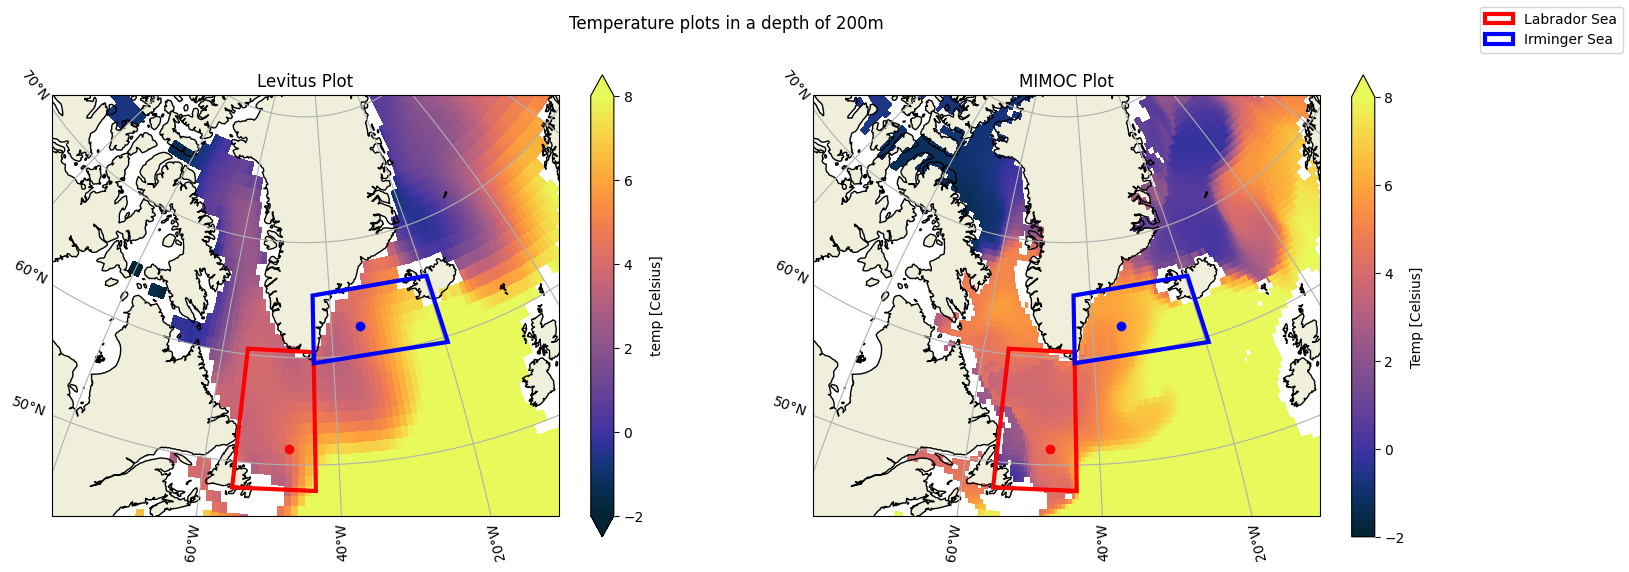

In [19]:
fig, axs = plt.subplots(
        figsize=(18,6),
        nrows=1, ncols=2,
        subplot_kw={"projection":map_projection_greenland},
        )
axs = axs.flatten()
ax1, ax2 = axs[0], axs[1]
fig.suptitle(f"Temperature plots in a depth of {depth_extent}m")
for ax in axs:
        ax.set_extent([west, east, south, north], crs=PlateCarree())
        basemap(ax)
        ax.add_patch(Rectangle(
                (labrador_extent["west"], labrador_extent["south"]), 
                labrador_extent["width"], labrador_extent["height"],
                lw=3, edgecolor="r", facecolor="None",
                zorder=10, transform=PlateCarree(),
                label="Labrador Sea",
        ))
        ax.add_patch(Rectangle(
                (irminger_extent["west"], irminger_extent["south"]), 
                irminger_extent["width"], irminger_extent["height"],
                lw=3, edgecolor="b", facecolor="None",
                zorder=10, transform=PlateCarree(), 
                label="Irminger Sea",
        ))
        ax.scatter(temp_profile_labrador_lon, temp_profile_labrador_lat, transform=PlateCarree(), c="r", zorder=10)
        ax.scatter(temp_profile_irminger_lon, temp_profile_irminger_lat, transform=PlateCarree(), c="b", zorder=10)

levitus_map_data.plot(ax=ax1, x="lon", y="lat", vmin=-2, vmax=8, transform=PlateCarree(), cmap=cm_thermal)
mimoc_map_data.plot(ax=ax2, x="lon", y="lat", vmin=-2, vmax=8, transform=PlateCarree(), cbar_kwargs={'label': "Temp [Celsius]"}, cmap=cm_thermal)
fig.legend(labels=list(("Labrador Sea", "Irminger Sea")))
ax1.set_title("Levitus Plot")
ax2.set_title("MIMOC Plot")
plt.show()

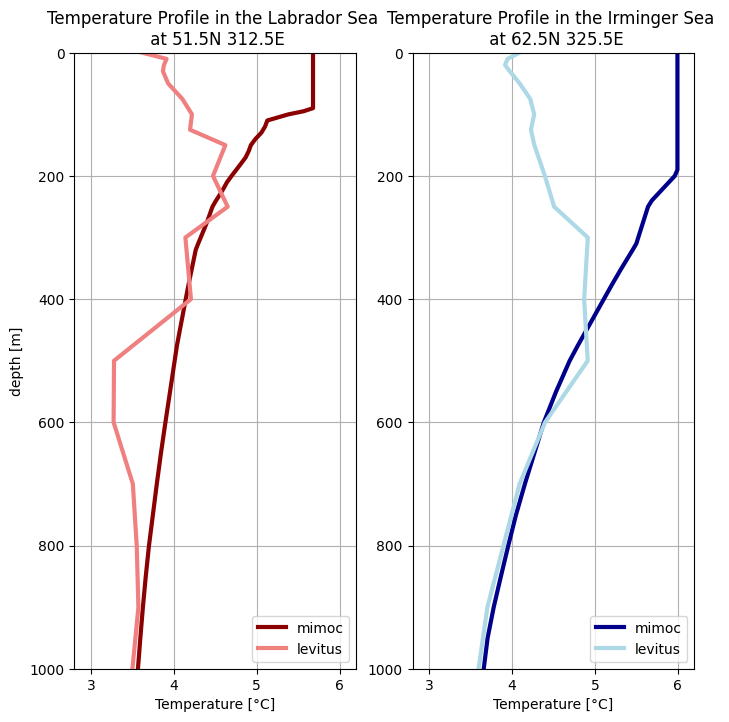

In [20]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(121)
ax1.invert_yaxis()
mimoc_temp_labrador_profile.potential_temperature.plot(ax=ax1, y="pre", c="darkred", label="mimoc", lw=3)
levitus_temp_labrador_profile.temp.plot(ax=ax1, y="depth", c="lightcoral", label="levitus", lw=3)
ax1.set_xlabel("Temperature [°C]")
ax1.set_xlim(2.8, 6.2)
ax1.set_ylabel("depth [m]")
ax1.set_ylim(1000,0)
ax1.grid()
ax1.set_title(f"Temperature Profile in the Labrador Sea \n at {temp_profile_labrador_lat}N {temp_profile_labrador_lon}E")
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.invert_yaxis()
mimoc_temp_irminger_profile.potential_temperature.plot(ax=ax2, y="pre", c="darkblue", label="mimoc", lw=3)
levitus_temp_irminger_profile.temp.plot(ax=ax2, y="depth", c="lightblue", label="levitus", lw=3)
ax2.set_xlabel("Temperature [°C]")
ax2.set_xlim(2.8, 6.2)
ax2.set_ylabel(None)
ax2.set_ylim(1000,0)
ax2.grid()
ax2.set_title(f"Temperature Profile in the Irminger Sea \n at {temp_profile_irminger_lat}N {temp_profile_irminger_lon}E")
ax2.legend()

plt.show()

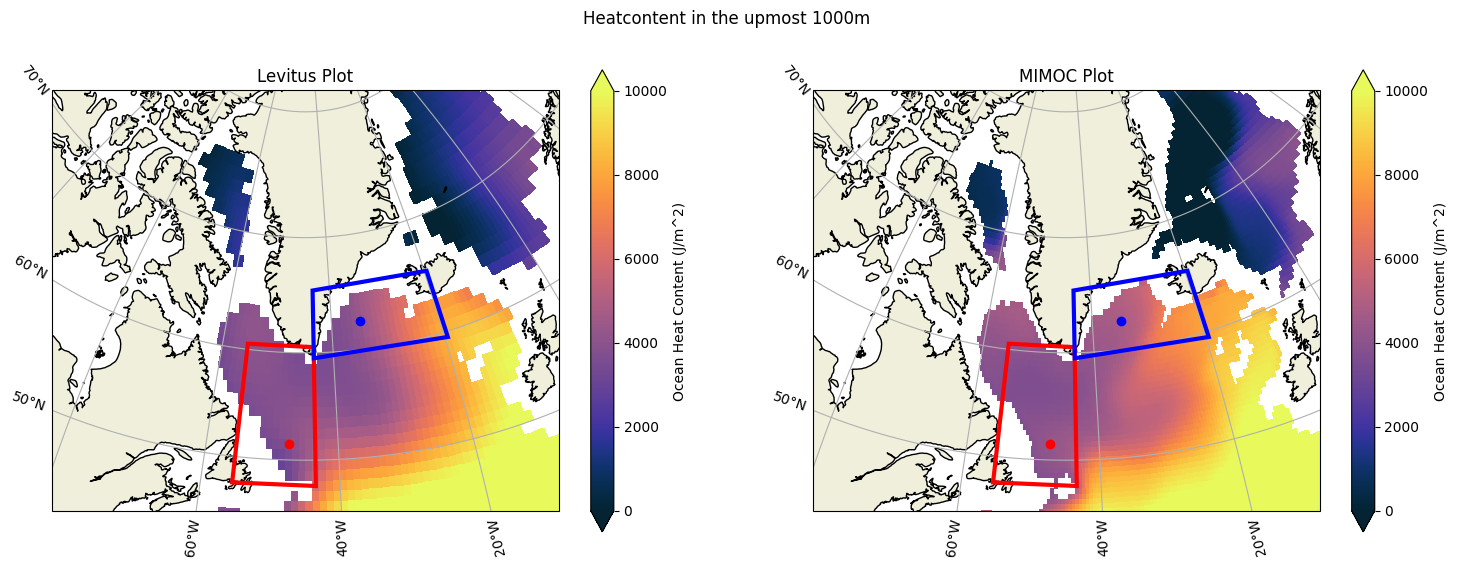

In [21]:
# Exercise 2.a.3.a
depth_extent = 1000
fig, axs = plt.subplots(
        figsize=(18,6),
        nrows=1, ncols=2,
        subplot_kw={"projection":map_projection_greenland},
        )
axs = axs.flatten()
ax1, ax2 = axs[0], axs[1]
fig.suptitle(f"Heatcontent in the upmost {depth_extent}m")
for ax in axs:
        ax.set_extent([west, east, south, north], crs=PlateCarree())
        basemap(ax)
        ax.add_patch(Rectangle(
                (labrador_extent["west"], labrador_extent["south"]), 
                labrador_extent["width"], labrador_extent["height"],
                lw=3, edgecolor="r", facecolor="None",
                zorder=10, transform=PlateCarree(),
        ))
        ax.add_patch(Rectangle(
                (irminger_extent["west"], irminger_extent["south"]), 
                irminger_extent["width"], irminger_extent["height"],
                lw=3, edgecolor="b", facecolor="None",
                zorder=10, transform=PlateCarree(),
        ))
        ax.scatter(temp_profile_labrador_lon, temp_profile_labrador_lat, transform=PlateCarree(), c="r", zorder=10)
        ax.scatter(temp_profile_irminger_lon, temp_profile_irminger_lat, transform=PlateCarree(), c="b", zorder=10)
levitus.sel(month=1, depth=slice(0,depth_extent)).integrate(coord="depth").temp.T.plot(ax=ax1, x="lon", y="lat", vmin=0, vmax=1e4, transform=PlateCarree(), 
                                                                                       cbar_kwargs={'label': "Ocean Heat Content (J/m^2)"}, cmap=cm_thermal)
mimoc.sel(pre=slice(0,depth_extent)).integrate(coord="pre").potential_temperature.T.plot(ax=ax2, x="lon", y="lat", vmin=0, vmax=1e4, transform=PlateCarree(), 
                                                                                         cbar_kwargs={'label': "Ocean Heat Content (J/m^2)"}, cmap=cm_thermal)
ax1.set_title("Levitus Plot")
ax2.set_title("MIMOC Plot")
plt.show()